<a href="https://colab.research.google.com/github/chochoswim/chochoswim.github.io/blob/master/project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from IPython.core.display import display, HTML
plt.rc('font', family='NanumBarunGothic') 

저는 게임을 나름 즐깁니다. 하지만 잘하지 못해요. 여러가지 문제가 있겠지만 우선 순발력이 좋지 못합니다. 멀티태스킹 능력도 현저히 떨어집니다. 즉, 게이머들이 흔히 말하는 ‘피지컬’이 현저히 떨어지는거죠.. 이 프로젝트는 떨어지는 ‘피지컬’을 데이터를 통한 ‘뇌지컬’로 극복하여 나도 게임을 잘할 수 있지 않을까? 하는 바람에 시작되었습니다.

저는 league of legend, 일명 롤이라는 게임을 꽤 오래 전부터 꾸준히 플레이해왔습니다. 시즌3인 2013년부터 랭크 게임을 시작했으니 어연 10년을 게임해온 것이죠. 그럼에도 불구하고 티어는 매번 실버 그대로입니다. 물론 많은 게임을 하지 않고, 즐겜러의 성향을 띄어 그런 것도 있습니다(라고 변명하고 싶다). 하지만 그래도 10년차 게이머가 한번은 골드는 가봐야하지 않을까요?

게임 데이터 수집은 라이엇 API를 활용하여 수집하였습니다.

[관련 링크](https://blog.naver.com/uhbsong/223112677211)

우선 어떤 챔피언을 선택하면 승리할 확률이 높을지 알아보려고합니다.

In [ ]:
df = pd.read_csv('loldata.csv')

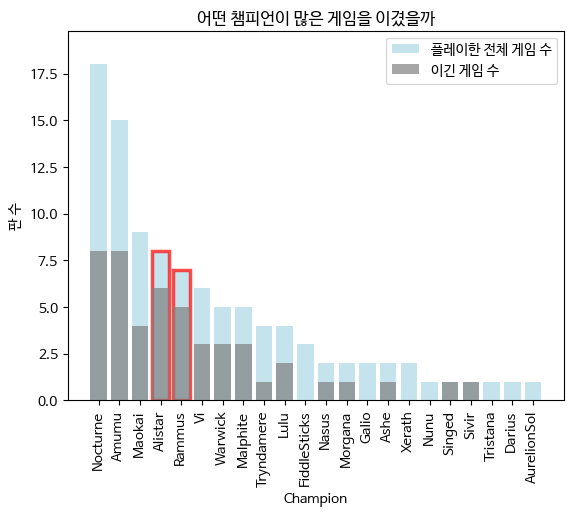

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 'championName' 열을 기준으로 그룹화하고 전체 판수와 이긴 판수 계산
grouped = df.groupby('championName').agg({'win': ['count', 'sum']})

# 판수를 기준으로 정렬
grouped_sorted = grouped.sort_values(('win', 'count'), ascending=False)

# 전체 판수와 이긴 판 수를 포함하는 막대 그래프 그리기
fig, ax = plt.subplots()

# 전체 판수를 나타내는 막대 그래프 (연한 파랑)
total_games = grouped_sorted[('win', 'count')]

# 이긴 판 수를 나타내는 막대 그래프 (회색)
wins = grouped_sorted[('win', 'sum')]

# 강조할 챔피언 인덱스 확인
highlight_champions = ['Rammus', 'Alistar']
highlight_indices = [grouped_sorted.index.get_loc(champion) for champion in highlight_champions]

# 막대 그래프 그리기
bars = ax.bar(grouped_sorted.index, total_games, color='lightblue', alpha=0.7, label='플레이한 전체 게임 수')

# 강조할 챔피언 막대에 굵은 테두리 표시
for index in highlight_indices:
    bars[index].set_edgecolor('red')
    bars[index].set_linewidth(2.5)
    bars[index].set_facecolor('lightblue')  # 내부 색상을 파랑으로 설정

ax.bar(grouped_sorted.index, wins, color='gray', alpha=0.7, label='이긴 게임 수')

# 그래프 제목과 축 제목 설정
plt.title('어떤 챔피언이 많은 게임을 이겼을까')
plt.xlabel('Champion')
plt.ylabel('판 수')

# 범례 표시
ax.legend()

# x축 레이블이 겹치지 않도록 설정
plt.xticks(rotation=90)

# y축 범위 설정
max_count = total_games.max()
max_wins = wins.max()
ax.set_ylim(0, max(max_count, max_wins) * 1.1)

# 그래프 표시
plt.show()

람머스와 알리스타가 어느정도 판 수를 채웠음에도 높은 승률을 보이고 있네요.

람머스는 정글로 활용하였고, 알리스타는 탑으로 활용하였습니다.

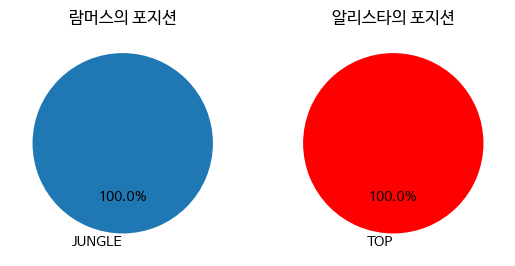

In [ ]:
# 챔피언별로 데이터 분리
rammus_data = df[df['championName'] == 'Rammus']
alistar_data = df[df['championName'] == 'Alistar']

# 각 챔피언의 포지션 데이터를 기반으로 그룹화하고, 각 그룹의 크기를 계산
rammus_position_counts = rammus_data['teamPosition'].value_counts()
alistar_position_counts = alistar_data['teamPosition'].value_counts()

# 두 개의 서브플롯 생성
fig, axs = plt.subplots(1, 2)

# 첫 번째 차트에 Rammus 데이터 표시
axs[0].pie(rammus_position_counts, labels=rammus_position_counts.index, autopct='%1.1f%%', startangle=90)
axs[0].set_title('람머스의 포지션')

# 두 번째 차트에 Alistar 데이터 표시
axs[1].pie(alistar_position_counts, labels=alistar_position_counts.index, autopct='%1.1f%%', startangle=90, colors=['red'])
axs[1].set_title('알리스타의 포지션')

# 차트 표시
plt.show()

운영적으로 게임을 풀어나갈 수 있는 것은 정글 포지션이기에 정글 람머스를 플레이한 게임 데이터를 좀더 깊게 살펴보려고 합니다.

정글 람머스로 어떻게 플레이를 하면 게임을 이길 수 있을까요?

In [ ]:
df_rammus = pd.read_csv('rammusdata.csv')

In [ ]:
df_rammus = df_rammus.fillna(0)

In [ ]:
# 범주형 변수를 이진형 변수로 변환합니다. (True는 1로, False는 0으로 변환)
df_rammus['win'] = df_rammus['win'].astype(int)

# 연속형 변수와 범주형 변수(win) 사이의 상관 관계를 계산합니다.
correlations = {}
continuous_columns = df_rammus.select_dtypes(include=[np.number]).columns.tolist()  # 연속형 변수 선택
for col in continuous_columns:
    if len(df_rammus[col].unique()) > 1:  # 고유한 값이 2개 이상인 경우만 선택
        pbc = stats.pointbiserialr(df_rammus[col], df_rammus['win'])
        correlations[col] = pbc[0]  # 상관 계수만 저장합니다.

# 상관계수를 내림차순으로 정렬합니다.
sorted_correlations = sorted(correlations.items(), key=lambda item: item[1], reverse=True)

# 상위 10개의 변수와 그들의 상관계수를 표시합니다.
for i in range(10):
    variable = sorted_correlations[i][0]
    correlation = sorted_correlations[i][1]
    
    # "turret"이 포함된 텍스트를 강조합니다.
    if "turret" in variable.lower():
        variable = f"<mark>{variable}</mark>"
    
    # 결과를 HTML 형식으로 변환합니다.
    result_html = HTML(f"{variable}: {correlation}")
    
    # 결과를 출력합니다.
    display(result_html)

게임 데이터 중에서 승리 여부와 높은 상관 계수를 가지고 있는 상위 10개의 변수를 표시했습니다.

turret이라는 단어가 많이 보이지 않나요?

정글 포지션이 얼마나 포탑을 많이 깨고 많은 딜량을 가했는지가 승패에 지대한 영향을 끼치는 것을 알 수 있습니다.


박스 플롯 그래프로 상관관계를 시각화해보았더니 확실한 상관관계를 가지는 것을 확인할 수 있습니다.

진 게임의 경우 포탑을 직접 깬 횟수가 단 한 차례였고, 포탑에 가한 데미지 역시 큰 차이를 볼 수 있습니다.

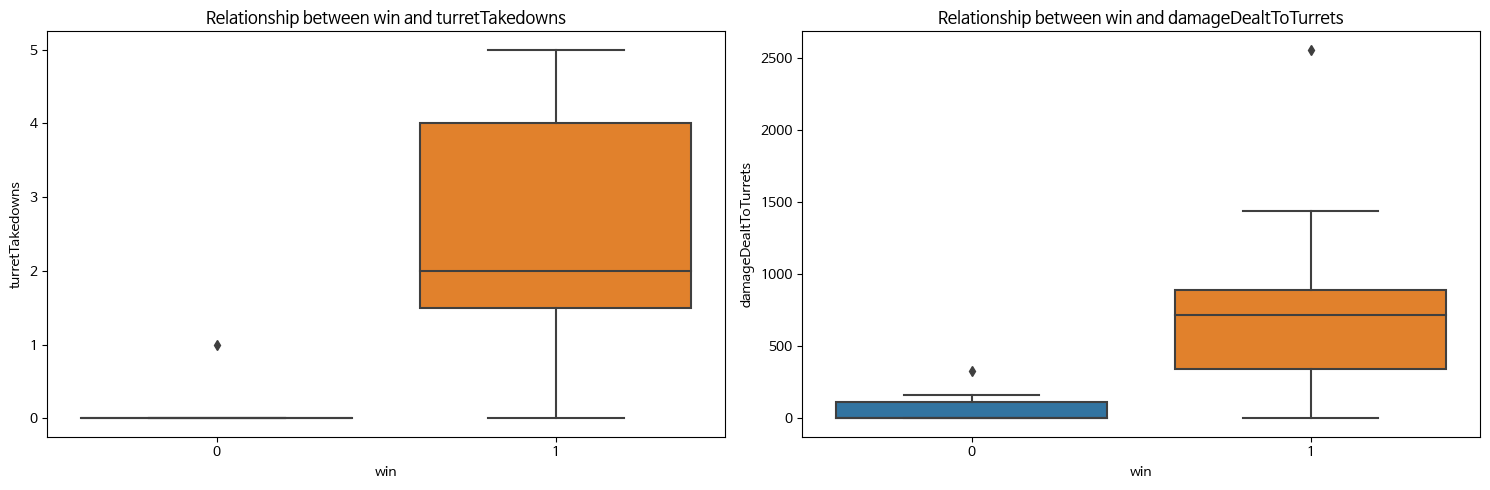

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 그래프 크기 설정 및 서브플롯 설정

variables = ['turretTakedowns', 'damageDealtToTurrets']

for i, var in enumerate(variables):
    sns.boxplot(x='win', y=var, data=df_rammus, ax=axs[i])
    axs[i].set_title(f'Relationship between win and {var}')

plt.tight_layout()  # 그래프 간격 조절
plt.show()

마지막으로 조그마한 데이터 셋이긴 하지만 명색이 데이터 분석이니 ML을 사용해볼까요?

포탑에 대한 데미지에 대해 로지스틱 회귀 모델을 사용해보았습니다.

정확도가 0.83이 나오네요. 재미로만 봐주세요.

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# 데이터를 피처(X)와 타겟(y)으로 분리
X = df_rammus['damageDealtToTurrets'].values.reshape(-1, 1)  # LogisticRegression 모델은 2D 배열 형태의 입력을 기대하므로 reshape가 필요합니다.
y = df_rammus['win']

# 데이터를 학습 세트와 테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 로지스틱 회귀 모델 생성 및 학습
model = LogisticRegression()
model.fit(X_train, y_train)

# 테스트 세트에서의 예측 및 성능 평가
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6



실제로 리그오브레전드에는 '죽밀라' 라는 단어가 있습니다.

챔피언이 죽어도 밀어야하는 라인을 이야기합니다. 아래와 같은 상황이죠

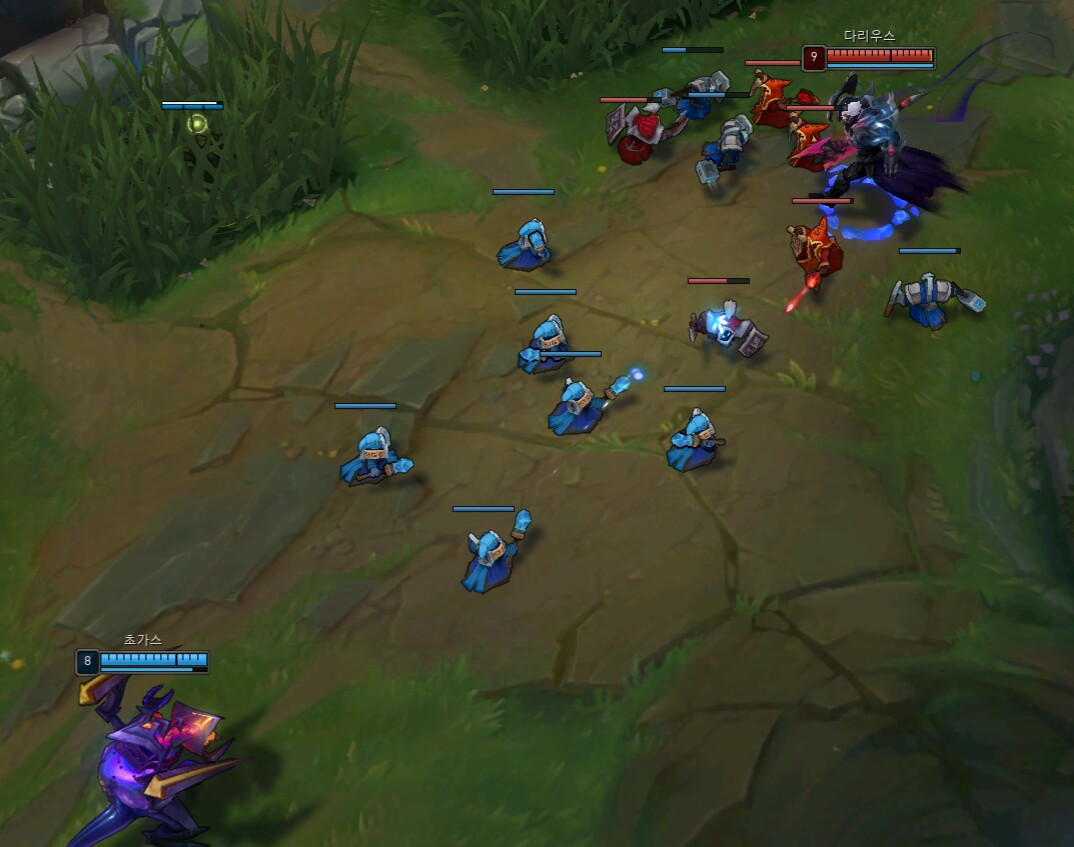

그만큼 포탑에 가하는 압력이 가지는 의미가 챔피언의 kda보다 중요하다는 것을 의미합니다.

물론, 리그오브레전드라는 게임은 너무 많은 변수가 존재하기에 한 가지 승리 패턴이란 없습니다.

그렇기 때문에 10년이 넘는 시간동안 많은 게이머들에게 독보적인 사랑을 받아왔습니다. 매판 새롭고 짜릿해..

그럼에도 불구하고 이 같은 데이터 분석 프로젝트를 통해 저의 람머스 정글 플레이의 리그오브레전드 승리의 ONETHING은 '상대 포탑에 대한 압력을 가해라!' 라고 주장합니다. 그래서 결국 리그오브레전드는 포탑깨는 게임이다. 라고 이야기하는 사람들도 많은 것 같습니다.

아쉬운 점이 많은 프로젝트지만 입사 전에 꼭 마무리해서 포스팅하기를 결심하였기 때문에 얼렁뚱땅 결론까지 지어봤습니다.

이 프로젝트를 시작할 때는 게임 회사에 합격 통보를 받지 않은 상태였는데 이제는 내일 첫 출근날이네요.
회사에 다니면서도 꾸준히 분석 관련 공부를 하며 발전시켜나가려고 합니다. 피드백은 언제나 환영입니다(해줬으면 좋겠다). 그럼 첫 개인 프로젝트 끝!